## Setup


In [ ]:
from pathlib import Path
from PIL import Image

from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import torch
from torch import autocast
from torchvision import transforms as tfms
from huggingface_hub import notebook_login

from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    LMSDiscreteScheduler
)
from diffusers.schedulers import (
    # PNDMScheduler,  # default
    LMSDiscreteScheduler,
    HeunDiscreteScheduler,
    DPMSolverMultistepScheduler  # Great quality with few steps (1/2 steps less)
)

from transformers import (
    CLIPTextModel,
    CLIPTokenizer,
    logging
)

In [ ]:
device = (
    "mps"
    if torch.backends.mps.is_available()
    else
    "cuda"
    if torch.cuda.is_available()
    else
    "cpu"
)

print(f"Using device: {device}")
dtype = torch.float16 if torch.cuda.is_available() else torch.float32
print(f"Using dtype: {dtype}")

if not (Path.home()/'.cache/huggingface'/'token').exists():
    notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

Using device: cuda
Using dtype: torch.float16


# Architecture

**1. The autoencoder (VAE)**

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the *U-Net* model.
The decoder, conversely, transforms the latent representation back into an image.

 During latent diffusion _training_, the encoder is used to get the latent representations (_latents_) of the images for the forward diffusion process, which applies more and more noise at each step. During _inference_, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. As we will see during inference we **only need the VAE decoder**.

**2. The U-Net**

The U-Net has an encoder part and a decoder part both comprised of ResNet blocks.
The encoder compresses an image representation into a lower resolution image representation and the decoder decodes the lower resolution image representation back to the original higher resolution image representation that is supposedly less noisy.
More specifically, the U-Net output predicts the noise residual which can be used to compute the predicted denoised image representation.

To prevent the U-Net from losing important information while downsampling, short-cut connections are usually added between the downsampling ResNets of the encoder to the upsampling ResNets of the decoder.
Additionally, the stable diffusion U-Net is able to condition its output on text-embeddings via cross-attention layers. The cross-attention layers are added to both the encoder and decoder part of the U-Net usually between ResNet blocks.

**3. The Text-encoder**

The text-encoder is responsible for transforming the input prompt, *e.g.* "An astronout riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple *transformer-based* encoder that maps a sequence of input tokens to a sequence of latent text-embeddings.

**Why is latent diffusion fast and efficient?**

Since the U-Net of latent diffusion models operates on a low dimensional space, it greatly reduces the memory and compute requirements compared to pixel-space diffusion models. For example, the autoencoder used in Stable Diffusion has a reduction factor of 8. This means that an image of shape `(3, 512, 512)` becomes `(3, 64, 64)` in latent space, which requires `8 × 8 = 64` times less memory.

This is why it's possible to generate `512 × 512` images so quickly, even on 16GB Colab GPUs!

# Inference Pipeline


### Loading Components


In [ ]:
from transformers import GenerationConfig, GPT2LMHeadModel, GPT2Tokenizer, LogitsProcessor, LogitsProcessorList

# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4",
                                    subfolder="vae",
                                    variant="fp16",)

# Load the tokenizer and text encoder to tokenize and encode the text.
# tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
tokenizer = GPT2Tokenizer.from_pretrained("Gustavosta/MagicPrompt-Stable-Diffusion",
                                          variant="fp16")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4",
                                            subfolder="unet",
                                            variant="fp16")

# The noise scheduler
lms_discrete_scheduler = LMSDiscreteScheduler(beta_start=0.00085,
                                              beta_end=0.012,
                                              beta_schedule="scaled_linear",
                                              num_train_timesteps=1000)
heun_discrete_scheduler = HeunDiscreteScheduler(beta_start=0.00085,
                                                beta_end=0.012,
                                                beta_schedule="scaled_linear",
                                                num_train_timesteps=1000)
dpm_solver_multistep_scheduler = DPMSolverMultistepScheduler(beta_start=0.00085,
                                                             beta_end=0.012,
                                                             beta_schedule="scaled_linear",
                                                             num_train_timesteps=1000,
                                                             prediction_type="epsilon",
                                                             # set solver_order to 2 for guide sampling, and solver_order=3 for unconditional sampling.
                                                             solver_order=2)
schedulers = {
    "lms_discrete": lms_discrete_scheduler,
    "heun_discrete": heun_discrete_scheduler,
    "dpm_solver_multistep": dpm_solver_multistep_scheduler
}
scheduler = schedulers["dpm_solver_multistep"]

vae = vae.to(device)
vae.eval()

text_encoder = text_encoder.to(device)
text_encoder.eval()

unet = unet.to(device)
unet.eval()

# generator = torch.manual_seed(torch.randint(0, 1000000, (1,)).item())
generator = torch.manual_seed(32)
batch_size = 1

## Inference Settings


In [ ]:
# Prompt for image generation
prompt = "an orange cat staring off with pretty eyes"

# Negative prompt to avoid unwanted features
negative_prompt = (
    "ugly, poorly rendered face, low resolution, poorly drawn feet, "
    "poorly drawn face, out of frame, extra limbs, disfigured, deformed, "
    "body out of frame, blurry, bad composition, blurred, watermark, grainy, "
    "signature, cut off, mutation"
)

# Style selection
# Available options:
# "gogh", "surealistic", "cinematic", "anime", "photographic", "comic", "lineart", "pixelart"
style = "cinematic"

# Image dimensions
height = 512  # must be divisible by 8
width = 512   # must be divisible by 8
# Diffusion steps and guidance
num_inference_steps = 250       # number of denoising steps
guidance_scale = 7.5            # classifier-free guidance scale


## Tokenizer and Text Encoder

![Text Pipeline](./figures/text-pipeline.png)

### Prompt Enhancement

GPT2 pretrained on Stable Diffusion text prompts to automatically enrich a prompt with additional important keywords to generate high-quality images.

The LogitsProcessor class assigns tokens in the words list a value of 0 and assigns tokens not in the words list a negative value so they aren’t picked during generation.
This way, generation is biased towards words in the words list. After a word from the list is used, it is also assigned a negative value so it isn’t picked again.
<!-- TODO: describe how this works -->

In [ ]:
# this specific checkpoint is trained to generate prompts which will enhance the original prompt
tokenizer = GPT2Tokenizer.from_pretrained("Gustavosta/MagicPrompt-Stable-Diffusion")
prompt_enhancer = GPT2LMHeadModel.from_pretrained("Gustavosta/MagicPrompt-Stable-Diffusion", torch_dtype=torch.float16).to(
    "cuda"
)
prompt_enhancer.eval()

styles = {
    "gogh": "{prompt}, in the style of Vincent van Gogh, impasto brushstrokes, swirling patterns, vibrant colors, expressionistic, oil on canvas",
    "surealistic": "surrealist art of {prompt}, dreamlike, Salvador Dalí inspired, bizarre, fantastical, melting forms, hyper-realistic details in an impossible setting",
    "cinematic": "cinematic film still of {prompt}, highly detailed, high budget hollywood movie, cinemascope, moody, epic, gorgeous, film grain",
    "anime": "anime artwork of {prompt}, anime style, key visual, vibrant, studio anime, highly detailed",
    "photographic": "cinematic photo of {prompt}, 35mm photograph, film, professional, 4k, highly detailed",
    "comic": "comic of {prompt}, graphic illustration, comic art, graphic novel art, vibrant, highly detailed",
    "lineart": "line art drawing {prompt}, professional, sleek, modern, minimalist, graphic, line art, vector graphics",
    "pixelart": " pixel-art {prompt}, low-res, blocky, pixel art style, 8-bit graphics",
}

words = [
    "aesthetic", "astonishing", "beautiful", "breathtaking", "composition", "contrasted", "epic", "moody", "enhanced",
    "exceptional", "fascinating", "flawless", "glamorous", "glorious", "illumination", "impressive", "improved",
    "inspirational", "magnificent", "majestic", "hyperrealistic", "smooth", "sharp", "focus", "stunning", "detailed",
    "intricate", "dramatic", "high", "quality", "perfect", "light", "ultra", "highly", "radiant", "satisfying",
    "soothing", "sophisticated", "stylish", "sublime", "terrific", "touching", "timeless", "wonderful", "unbelievable",
    "elegant", "awesome", "amazing", "dynamic", "trendy",
]

word_pairs = ["highly detailed", "high quality", "enhanced quality", "perfect composition", "dynamic light"]


def find_and_order_pairs(s, pairs):
    words = s.split()
    found_pairs = []
    for pair in pairs:
        pair_words = pair.split()
        if pair_words[0] in words and pair_words[1] in words:
            found_pairs.append(pair)
            words.remove(pair_words[0])
            words.remove(pair_words[1])

    for word in words[:]:
        for pair in pairs:
            if word in pair.split():
                words.remove(word)
                break
    ordered_pairs = ", ".join(found_pairs)
    remaining_s = ", ".join(words)
    return ordered_pairs, remaining_s


class CustomLogitsProcessor(LogitsProcessor):
    def __init__(self, bias):
        super().__init__()
        self.bias = bias

    def __call__(self, input_ids, scores):
        if len(input_ids.shape) == 2:
            last_token_id = input_ids[0, -1]
            self.bias[last_token_id] = -1e10
        return scores + self.bias

word_ids = [tokenizer.encode(word, add_prefix_space=True)[0] for word in words]
bias = torch.full((tokenizer.vocab_size,), -float("Inf")).to("cuda")
bias[word_ids] = 0
processor = CustomLogitsProcessor(bias)
processor_list = LogitsProcessorList([processor])

In [ ]:
print(f"Original prompt: {prompt}")

prompt = styles[style].format(prompt=prompt)
print(f"Styled prompt: {prompt}")

inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
token_count = inputs["input_ids"].shape[1]
max_new_tokens = 50 - token_count

generation_config = GenerationConfig(
    penalty_alpha=0.7,
    top_k=50,
    eos_token_id=text_encoder.config.eos_token_id,
    pad_token_id=text_encoder.config.eos_token_id,
    pad_token=text_encoder.config.pad_token_id,
    do_sample=True,
)

with torch.no_grad():
    generated_ids = prompt_enhancer.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        generation_config=generation_config,
        logits_processor=processor_list,
    )

output_tokens = [tokenizer.decode(generated_id, skip_special_tokens=True) for generated_id in generated_ids]
input_part, generated_part = output_tokens[0][: len(prompt)], output_tokens[0][len(prompt):]
pairs, words = find_and_order_pairs(generated_part, word_pairs)
formatted_generated_part = pairs + ", " + words
enhanced_prompt = input_part + ", " + formatted_generated_part
print(f"Enhanced prompt: {enhanced_prompt}")

Original prompt: an orange cat staring off with pretty eyes
Styled prompt: cinematic film still of an orange cat staring off with pretty eyes, highly detailed, high budget hollywood movie, cinemascope, moody, epic, gorgeous, film grain
Enhanced prompt: cinematic film still of an orange cat staring off with pretty eyes, highly detailed, high budget hollywood movie, cinemascope, moody, epic, gorgeous, film grain, high quality, sharp, focus, beautiful, intricate, stunning, amazing, smooth, mood


### Prompt Encoding

We use a text encoder model to turn our text into a set of 'embeddings' which are fed to the diffusion model as conditioning.

The goal of the text encoder is to turn an input string (the prompt) into a numerical representation that can be fed to the UNet as conditioning. The text is first turned into a series of tokens using the pipeline's tokenizer. The text encoder has a vocabulary of about 50k tokens - any word isn't in this vocabulary is split into smaller sub-words. The tokens are then fed through the text encoder model itself - a transformer model that was originally trained as the text encoder for CLIP. The hope is that this pretrained transformer model has learnt rich representations of text that will be useful for the diffusion task too


In [ ]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

tokens = tokenizer([enhanced_prompt],
                   padding="max_length",
                   max_length=tokenizer.model_max_length,
                   truncation=True,
                   return_tensors="pt")

# Conditional embeddings
with torch.no_grad():
    text_embeddings = text_encoder(tokens.input_ids.to(device))[0]
max_length = tokens.input_ids.shape[-1]

# Unconditional embeddings
# uncond_input = tokenizer([""] * batch_size,
uncond_input = tokenizer(negative_prompt * batch_size,
                         padding="max_length",
                         max_length=tokenizer.model_max_length,
                         truncation=True,
                         return_tensors="pt")
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
# Final embeddings
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
# text_embeddings = torch.cat([uncond_embeddings, mixed_embeddings])

# Info
print(f"Input IDS shape: {tokens['input_ids'].shape}")
print(f"Tokens: {tokens}")

for t in tokens["input_ids"][0]:
    print(f"token {t.item()}: {tokenizer.decode([t.item()])}")

print(f"Text embeddings shape: {text_embeddings.shape}")

Input IDS shape: torch.Size([1, 77])
Tokens: {'input_ids': tensor([[49406, 25602,  1860,  1170,   539,   550,  4287,  2368, 13800,  1007,
           593,  2111,  3095,   267,  5302, 12609,   267,  1400,  5639,  5518,
          2016,   267, 38251,  7979,   267, 17170,   267,  4991,   267,  3241,
           267,  1860, 12109,   267,  1400,  3027,   267,  8157,   267,  4353,
           267,  1215,   267, 29616,   267,  3769,   267,  1370,   267,  8990,
           267,  5394, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}
token 49406: <|startoftext|>
token 2560

These text embeddings (the so-called 'hidden states' of the last transformer block in the text encoder model) will be fed to the UNet as an additional argument to the forward method,

## U-Net

The UNet takes a noisy input and predicts the noise. The input is a latent representation of an image. It takes as input:
- The timestep conditioning.
- The text embeddings of the prompt (and optional negative prompt).
- Noisy latent representations.

### Noise Scheduler Configuration

The scheduler stores the noise schedule and manages updating the noisy sample based on the model predictions.

During sampling, we'll start at a high noise level (in fact, our input will be pure noise) and gradually 'denoise' down to an image, according to this schedule.

**This 'sigma' is the amount of noise added to the latent representation.**

Steps corresponding to the original training timesteps: tensor([999., 995., 991., 987., 983., 979., 975., 971., 967., 963., 959., 955.,
        951., 947., 943., 939., 935., 931., 927., 923., 919., 915., 911., 907.,
        903., 899., 895., 891., 887., 883., 879., 875., 871., 867., 863., 859.,
        855., 851., 847., 843., 839., 835., 831., 827., 823., 819., 815., 811.,
        807., 803., 799., 795., 791., 787., 783., 779., 775., 771., 767., 763.,
        759., 755., 751., 747., 743., 739., 735., 731., 727., 723., 719., 715.,
        711., 707., 703., 699., 695., 691., 687., 683., 679., 675., 671., 667.,
        663., 659., 655., 651., 647., 643., 639., 635., 631., 627., 623., 619.,
        615., 611., 607., 603., 599., 595., 591., 587., 583., 579., 575., 571.,
        567., 563., 559., 555., 551., 547., 543., 539., 535., 531., 527., 523.,
        519., 515., 511., 507., 503., 500., 496., 492., 488., 484., 480., 476.,
        472., 468., 464., 460., 456., 452., 448., 444., 440., 43

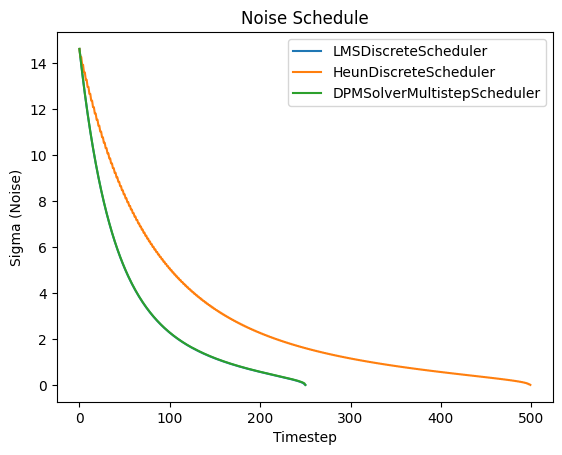

In [ ]:
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)


# Visualize the scheduler timesteps
for scheduler in schedulers.values():
    set_timesteps(scheduler, num_inference_steps)
    sigmas = scheduler.sigmas.cpu().numpy()
    timesteps = scheduler.timesteps.cpu().numpy()
    plt.plot(sigmas, label=scheduler.__class__.__name__)

print(f"Steps corresponding to the original training timesteps: {scheduler.timesteps}")
print(f"Noise Sigma at each timestep: {scheduler.sigmas}")

plt.title("Noise Schedule")
plt.xlabel("Timestep")
plt.ylabel("Sigma (Noise)")
plt.legend()
plt.show()

### Prepare Noisy Latent Representations

The model will transform this latent representation (pure noise) into an image later on.

In [ ]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(device)
latents = latents * scheduler.init_noise_sigma  # Scaling
print(f"Latents shape: {latents.shape}")

Latents shape: torch.Size([1, 4, 64, 64])


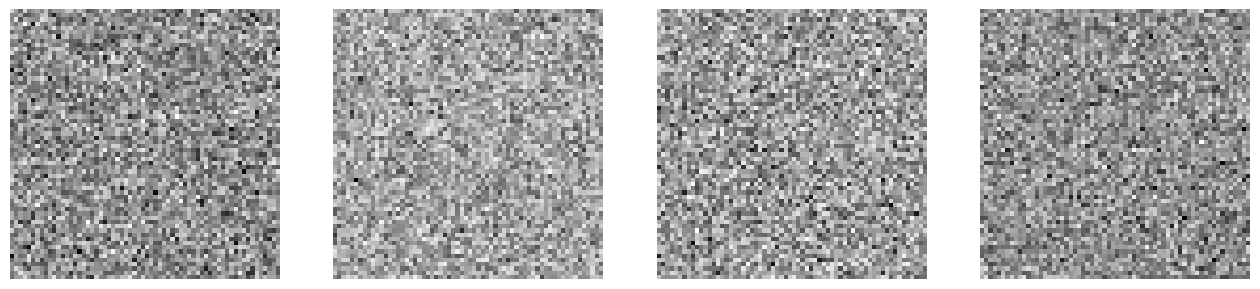

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latents[0][c].cpu(), cmap='Greys')
    axs[c].axis('off')

### Diffusion Loop (Denoising)

The U-Net takes in the noisy latents and predicts the amount of noise.

We use a **conditional model** that uses as conditioning elements:
* The timestep (t)
* Text Embeddings (prompt + negative prompt)

In [ ]:
with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/250 [00:00<?, ?it/s]

## VAE

The VAE (variational autoencoder) is a type of model that can encode its input into a compressed representation and then decode this 'latent' representation back into something close to the original input.

When generating images with Stable Diffusion, we first generate the latents by applying the diffusion process in the 'latent space' of the VAE, and then decode them at the end to view the resulting image.

![VAE](./figures/VAE.png)

In [ ]:
def pil_to_latent(input_im):
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(device)*2-1)
    return 0.18215 * latent.latent_dist.sample()


def latents_to_pil(latents):
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

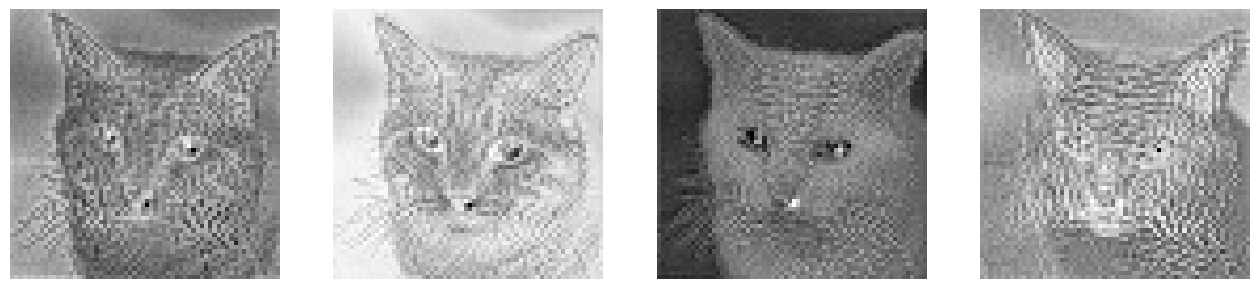

In [ ]:
# Visualize latents
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latents[0][c].cpu(), cmap='Greys')
    axs[c].axis('off')

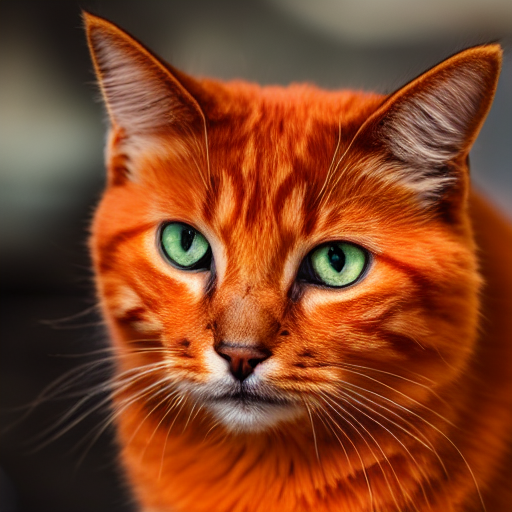

In [ ]:
decoded = latents_to_pil(latents)
decoded[0]

In [ ]:
import datetime
import uuid

today = datetime.datetime.now().strftime("%Y_%m_%d")
id= str(uuid.uuid4())[:8]

decoded[0].save(f"{today}_{id}.png")

In [ ]:
id

'076507a8'

# Metrics

In [ ]:
!pip install torchmetrics

In [ ]:
from torchvision.transforms import functional as F
import torch

import numpy as np

from torchmetrics.functional.multimodal import clip_score
from functools import partial


def preprocess_image(image):
    image = torch.tensor(image).unsqueeze(0)
    image = image.permute(0, 3, 1, 2) / 255.0
    image = F.center_crop(image, (256, 256))
    return image

clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")
def calculate_clip_score(images, prompts):
    images_int = (images * 255).astype("uint8")
    clip_score = clip_score_fn(torch.from_numpy(images_int).permute(0, 3, 1, 2), prompts).detach()
    return round(float(clip_score), 4)

In [ ]:
sd_clip_score = calculate_clip_score(np.asarray(decoded), prompt)
print(f"CLIP Score: {sd_clip_score}")

CLIP Score: 25.8492
